# Variational Autoencoder

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils

TensorFlow 1.x selected.


Using TensorFlow backend.


### Variational Autoencoder

### Negative Variational Lower Bound

In [8]:
def vlb_binomial(x, x_decoded_mean, t_mean, t_log_var):
    """Returns the value of negative Variational Lower Bound
    
    The inputs are tf.Tensor
        x: (batch_size x number_of_pixels) matrix with one image per row with zeros and ones
        x_decoded_mean: (batch_size x number_of_pixels) mean of the distribution p(x | t), real numbers from 0 to 1
        t_mean: (batch_size x latent_dim) mean vector of the (normal) distribution q(t | x)
        t_log_var: (batch_size x latent_dim) logarithm of the variance vector of the (normal) distribution q(t | x)
    
    Returns:
        A tf.Tensor with one element (averaged across the batch), VLB
    """

    # VLB = Sum_i( Expected_q_i( log( px_i | t_i, w ) ) - KL( q_i(t_i) || p(t_i) ))
    # First let's do KL(q||p) = Expected_q_i(log(q/p)) = Expected_q_i(-log(p/q))
    kl_inner = 0.5*(-t_log_var + tf.exp(t_log_var) + t_mean**2 - 1)
    # Now mean on the dimension axis per image
    kl = tf.reduce_sum(kl_inner, axis = 1)

    # Now let's do the first term, which reduces to Expected_q_i(log(p(x_i|t_i,w)))
    # For continuous variables this would be recloss_inner = - 0.5 * (x - x_decoded_mean)**2, but here we are using 
    recloss_inner = x*tf.log(x_decoded_mean+1e-9) + (1-x)*tf.log(1-x_decoded_mean+1e-9)
    recloss = - tf.reduce_sum(recloss_inner, 1)

    VLB = tf.reduce_mean(recloss) + tf.reduce_mean(kl)

    return VLB

In [4]:
# Start tf session so we can run code.
sess = tf.InteractiveSession()
# Connect keras to the created session.
tf.keras.backend.set_session(sess)

init = tf.global_variables_initializer()
sess.run(init)

## Encoder / decoder definition

In [9]:
from keras.models import Sequential

batch_size = 100
original_dim = 784 # Number of pixels in MNIST images.
latent_dim = 64 # d, dimensionality of the latent code t.
intermediate_dim = 256 # Size of the hidden layer.
epochs = 3

x = Input(batch_shape=(batch_size, original_dim))
def create_encoder(input_dim):
    # Encoder network.
    # We instantiate these layers separately so as to reuse them later
    encoder = Sequential(name='encoder')
    encoder.add(InputLayer([input_dim]))
    encoder.add(Dense(intermediate_dim, activation='relu'))
    encoder.add(Dense(2 * latent_dim))
    return encoder
encoder = create_encoder(original_dim)

get_t_mean = Lambda(lambda h: h[:, :latent_dim])
get_t_log_var = Lambda(lambda h: h[:, latent_dim:])
h = encoder(x)
t_mean = get_t_mean(h)
t_log_var = get_t_log_var(h)

# Sampling from the distribution 
#     q(t | x) = N(t_mean, exp(t_log_var))
# with reparametrization trick.
def sampling(args):
    """Returns sample from a distribution N(args[0], diag(args[1]))
    
    The sample should be computed with reparametrization trick.
    
    The inputs are tf.Tensor
        args[0]: (batch_size x latent_dim) mean of the desired distribution
        args[1]: (batch_size x latent_dim) logarithm of the variance vector of the desired distribution
    
    Returns:
        A tf.Tensor of size (batch_size x latent_dim), the samples.
    """
    t_mean, t_log_var = args

    eps = tf.random.normal(
      t_mean.shape, mean=0.0, stddev=1.0, dtype=tf.dtypes.float32
    )
    t = tf.multiply(eps, tf.exp(0.5 * t_log_var)) + t_mean
    return t


t = Lambda(sampling)([t_mean, t_log_var])

def create_decoder(input_dim):
    # Decoder network
    # We instantiate these layers separately so as to reuse them later
    decoder = Sequential(name='decoder')
    decoder.add(InputLayer([input_dim]))
    decoder.add(Dense(intermediate_dim, activation='relu'))
    decoder.add(Dense(original_dim, activation='sigmoid'))
    return decoder
decoder = create_decoder(latent_dim)
x_decoded_mean = decoder(t)

## Training the model

In [11]:
loss = vlb_binomial(x, x_decoded_mean, t_mean, t_log_var)
vae = Model(x, x_decoded_mean)
# Keras will provide input (x) and output (x_decoded_mean) to the function that
# should construct loss, but since our function also depends on other
# things (e.g. t_means), it is easier to build the loss in advance and pass
# a function that always returns it.
vae.compile(optimizer='rmsprop', loss=lambda x, y: loss)

#### Load and prepare the data

In [13]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

#### Train the model

In [14]:
hist = vae.fit(x=x_train, y=x_train,
               shuffle=True,
               epochs=1,
               batch_size=batch_size,
               validation_data=(x_test, x_test),
               verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 162.6858 - val_loss: 137.3358


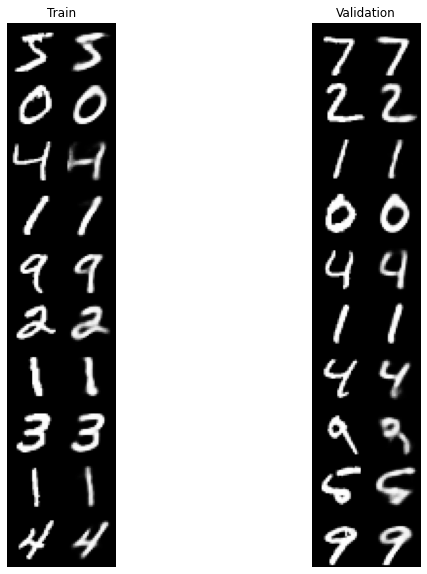

In [ ]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (data, title) in enumerate(
            zip([x_train, x_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(x_decoded_mean, feed_dict={x: data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Hallucinating new data
**Task 4** Write code to generate new samples of images from your trained VAE. To do that you have to sample from the prior distribution $p(t)$ and then from the likelihood $p(x \mid t)$.

**Note** that the sampling you've written in Task 2 was for the variational distribution $q(t \mid x)$, while here you need to sample from the prior.

In [ ]:
n_samples = 10  # To pass automatic grading please use at least 2 samples here.
# YOUR CODE HERE.
t = tf.random.normal(
  (n_samples, latent_dim), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32
)
# sampled_im_mean is a tf.Tensor of size 10 x 784 with 10 random
# images sampled from the vae model.
sampled_im_mean = decoder(t)

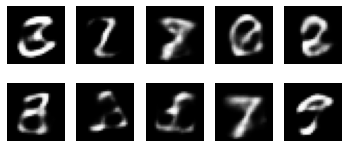

In [ ]:
sampled_im_mean_np = sess.run(sampled_im_mean)
# Show the sampled images.
plt.figure()
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(sampled_im_mean_np[i, :].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

# Conditional VAE

In [ ]:
# One-hot labels placeholder.
x = Input(batch_shape=(batch_size, original_dim))
label = Input(batch_shape=(batch_size, 10))

# YOUR CODE HERE.
cond_enc_input = concatenate([x, label])
cond_encoder = create_encoder(original_dim + 10)(cond_enc_input)

cond_t_mean = get_t_mean(cond_encoder) # Mean of the latent code (without label) for cvae model.
cond_t_log_var = get_t_log_var(cond_encoder) # Logarithm of the variance of the latent code (without label) for cvae model.

t = Lambda(sampling)([cond_t_mean, cond_t_log_var])

decoder = create_decoder(latent_dim + 10)
cond_dec_input = concatenate([t, label])
cond_x_decoded_mean = decoder(cond_dec_input) # Final output of the cvae model.

## Define the loss and the model

In [ ]:
conditional_loss = vlb_binomial(x, cond_x_decoded_mean, cond_t_mean, cond_t_log_var)
cvae = Model([x, label], cond_x_decoded_mean)
cvae.compile(optimizer='adam', loss=lambda x, y: conditional_loss)

### Train the model

In [ ]:
conditional_loss = vlb_binomial(x, cond_x_decoded_mean, cond_t_mean, cond_t_log_var)
cvae = Model([x, label], cond_x_decoded_mean)
cvae.compile(optimizer='adam', loss=lambda x, y: conditional_loss)

hist = cvae.fit(x=[x_train, y_train],
                y=x_train,
                shuffle=True,
                epochs=epochs*5,
                batch_size=batch_size,
                validation_data=([x_test, y_test], x_test),
                verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
 - 3s - loss: 167.1288 - val_loss: 132.9017
Epoch 2/15
 - 2s - loss: 125.8817 - val_loss: 118.6887
Epoch 3/15
 - 2s - loss: 116.2504 - val_loss: 112.3019
Epoch 4/15
 - 2s - loss: 111.6742 - val_loss: 109.2952
Epoch 5/15
 - 2s - loss: 109.1661 - val_loss: 107.7235
Epoch 6/15
 - 2s - loss: 107.4798 - val_loss: 106.1588
Epoch 7/15
 - 2s - loss: 106.3396 - val_loss: 104.9827
Epoch 8/15
 - 2s - loss: 105.4433 - val_loss: 104.3283
Epoch 9/15
 - 2s - loss: 104.7188 - val_loss: 103.6426
Epoch 10/15
 - 2s - loss: 104.1518 - val_loss: 103.1721
Epoch 11/15
 - 2s - loss: 103.6641 - val_loss: 102.9794
Epoch 12/15
 - 2s - loss: 103.1564 - val_loss: 102.5966
Epoch 13/15
 - 2s - loss: 102.8898 - val_loss: 102.0587
Epoch 14/15
 - 2s - loss: 102.5197 - val_loss: 102.0159
Epoch 15/15
 - 2s - loss: 102.2130 - val_loss: 101.5025


### Visualize reconstructions for train and validation data

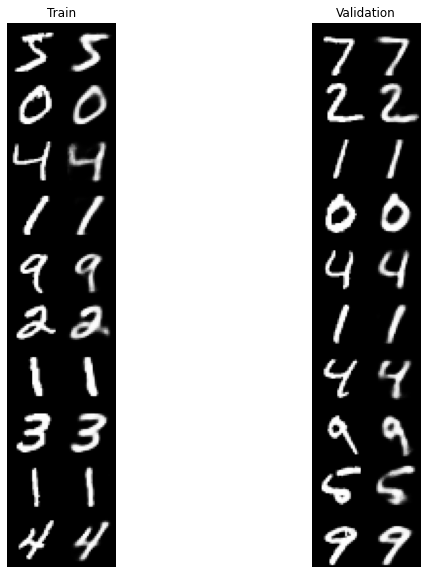

In [ ]:
fig = plt.figure(figsize=(10, 10))
for fid_idx, (x_data, y_data, title) in enumerate(
            zip([x_train, x_test], [y_train, y_test], ['Train', 'Validation'])):
    n = 10  # figure with 10 x 2 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * 2))
    decoded = sess.run(cond_x_decoded_mean,
                       feed_dict={x: x_data[:batch_size, :],
                                  label: y_data[:batch_size, :]})
    for i in range(10):
        figure[i * digit_size: (i + 1) * digit_size,
               :digit_size] = x_data[i, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    ax = fig.add_subplot(1, 2, fid_idx + 1)
    ax.imshow(figure, cmap='Greys_r')
    ax.set_title(title)
    ax.axis('off')
plt.show()

## Conditionally hallucinate data
**Task 5.2** Implement the conditional sampling from the distribution $p(x \mid t, \text{label})$ by firstly sampling from the prior $p(t)$ and then sampling from the likelihood $p(x \mid t, \text{label})$.

In [ ]:
# Prepare one hot labels of form
#   0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 ...
# to sample five zeros, five ones, etc
curr_labels = np.eye(10)
curr_labels = np.repeat(curr_labels, 5, axis=0)  # Its shape is 50 x 10.
# YOUR CODE HERE.
for j in range(len(curr_labels)):
  curr_labels[j] = (j // 10) * curr_labels[j]
curr_labels = tf.convert_to_tensor(curr_labels, dtype=tf.float32)

t = tf.random.normal(
  (50, latent_dim), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32
)
dec_input = concatenate([t, curr_labels])

# cond_sampled_im_mean is a tf.Tensor of size 50 x 784 with 5 random zeros,
# then 5 random ones, etc sampled from the cvae model.
cond_sampled_im_mean = decoder(dec_input)

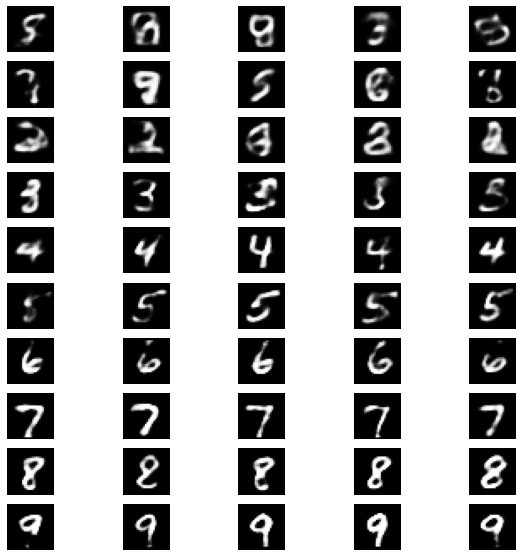

In [ ]:
cond_sampled_im_mean_np = sess.run(cond_sampled_im_mean)
# Show the sampled images.
plt.figure(figsize=(10, 10))
global_idx = 0
for digit in range(10):
    for _ in range(5):
        ax = plt.subplot(10, 5, global_idx + 1)
        plt.imshow(cond_sampled_im_mean_np[global_idx, :].reshape(28, 28), cmap='gray')
        ax.axis('off')
        global_idx += 1
plt.show()